In [1]:
import numpy as np
import tensorflow as tf

In [2]:
import tensorflow_datasets as tfds
(test, valid, train), info = tfds.load('tf_flowers', as_supervised=True,
                                       split = ['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
                                       with_info=True, try_gcs=True)

In [3]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [4]:
num_train_img = info.splits['train[25%:]'].num_examples
num_valid_img = info.splits['train[10%:25%]'].num_examples
num_test_img = info.splits['train[:10%]'].num_examples
print ('train images:', num_train_img)
print ('valid images:', num_valid_img)
print ('test images:', num_test_img)

train images: 2752
valid images: 551
test images: 367


In [5]:
class_labels = info.features['label'].names
num_classes = info.features['label'].num_classes
class_labels, num_classes

(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'], 5)

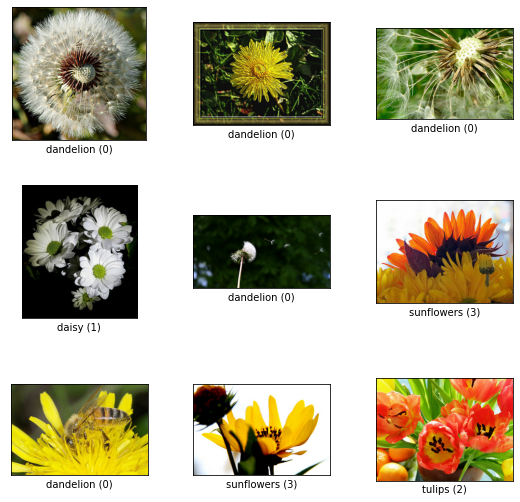

In [6]:
fig = tfds.show_examples(train, info)

In [7]:
for i, example in enumerate(train.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (240, 240, 3) label: 0
Image 2 shape: (375, 500, 3) label: 0
Image 3 shape: (334, 500, 3) label: 0
Image 4 shape: (240, 207, 3) label: 1
Image 5 shape: (265, 500, 3) label: 0


In [8]:
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) /255.0
    return image, label

In [9]:
BATCH_SIZE = 326
train_batches = train.shuffle(num_train_img//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = valid.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test.map(format_image).batch(BATCH_SIZE).prefetch(1)

BATCH_SIZE 326으로 수정

In [10]:
inception_v3 = tf.keras.applications.InceptionV3
inception_model = inception_v3(include_top=False, weights='imagenet',
                               input_shape=(224, 224, 3))

In [11]:
tf.keras.utils.plot_model(
    inception_model,
    show_shapes=True,
    show_layer_names=True)

In [12]:
len(inception_model.layers)

311

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [14]:
for layer in inception_model.layers:
  layer.trainable = False

In [15]:
xferred_model = tf.keras.Sequential([inception_model,
                                     GlobalAveragePooling2D(),
                                     Dropout(0.5),
                                     Dense(num_classes, activation='softmax')
                                     ])

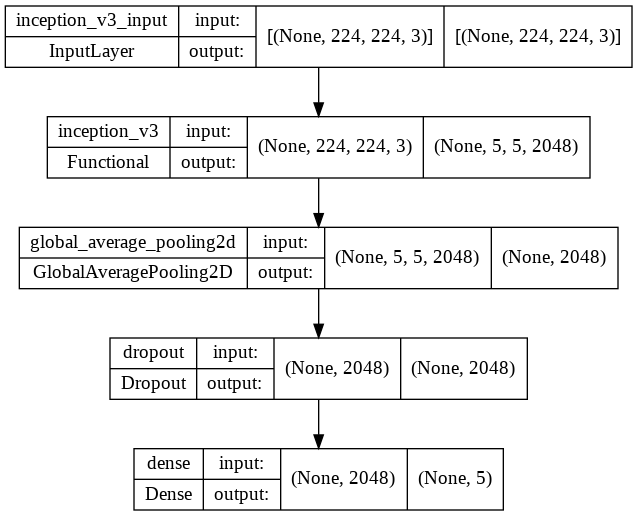

In [16]:
tf.keras.utils.plot_model(xferred_model,
                          show_shapes=True,
                          show_layer_names=True)

In [17]:
xferred_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=tf.keras.optimizers.SGD(learning_rate=0.22, momentum=0.9, decay=0.01),
                      metrics=['accuracy'])

learning_rate 를 0.22로 수정

In [18]:
EPOCHS = 28
history = xferred_model.fit(train_batches, epochs=EPOCHS, 
                            validation_data=validation_batches)

Epoch 1/28
9/9 [==============================] - 33s 2s/step - loss: 28.9712 - accuracy: 0.3219 - val_loss: 20.9815 - val_accuracy: 0.6189
Epoch 2/28
9/9 [==============================] - 6s 678ms/step - loss: 14.8086 - accuracy: 0.6966 - val_loss: 14.7455 - val_accuracy: 0.7024
Epoch 3/28
9/9 [==============================] - 6s 682ms/step - loss: 11.8221 - accuracy: 0.7547 - val_loss: 12.6032 - val_accuracy: 0.7623
Epoch 4/28
9/9 [==============================] - 6s 683ms/step - loss: 8.1727 - accuracy: 0.8078 - val_loss: 7.8921 - val_accuracy: 0.7985
Epoch 5/28
9/9 [==============================] - 6s 688ms/step - loss: 6.4721 - accuracy: 0.8169 - val_loss: 6.7706 - val_accuracy: 0.8221
Epoch 6/28
9/9 [==============================] - 6s 688ms/step - loss: 5.1423 - accuracy: 0.8412 - val_loss: 5.8547 - val_accuracy: 0.8113
Epoch 7/28
9/9 [==============================] - 6s 691ms/step - loss: 4.6640 - accuracy: 0.8517 - val_loss: 4.8825 - val_accuracy: 0.8203
Epoch 8/28
9/9 [

Epochs값 22로 수정
EPochs값 25로 수정
Epochs값 28로 수정


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12610 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12610 missing from current font.
  font.set_text(s, 0, flags=flags)


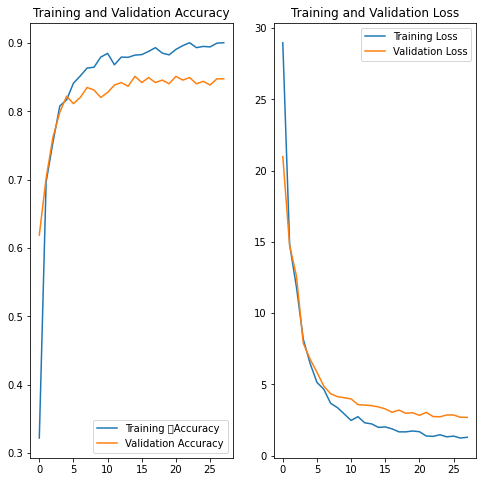

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training ㅂAccuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
predictions = xferred_model.predict(test_batches)

In [21]:
class_labels

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [22]:
predictions[0]

array([0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 8.7180485e-27,
       2.8522486e-14], dtype=float32)

In [23]:
predicted_id = np.argmax(predictions[0])
predicted_id

2

In [24]:
class_labels[predicted_id]

'tulips'

In [25]:
for img, lbl in test_batches.take(1):
    print(lbl)

tf.Tensor(
[2 3 3 4 3 0 0 0 0 1 3 2 4 1 2 1 2 4 2 2 0 0 0 2 0 3 0 1 1 1 2 1 0 0 1 1 0
 3 0 4 4 3 0 4 3 3 2 4 0 1 2 1 3 0 1 4 1 0 2 3 0 0 4 0 1 1 0 1 2 4 3 3 0 3
 2 2 1 0 3 2 0 0 4 3 0 3 3 2 0 2 1 4 0 3 3 3 1 4 0 4 4 4 4 0 4 2 3 4 0 0 4
 4 4 2 2 4 4 3 3 0 3 2 0 1 2 1 4 3 0 2 0 2 2 4 0 3 0 0 1 2 0 1 2 3 1 2 2 0
 3 3 4 0 4 0 4 0 2 2 1 0 2 4 0 0 0 1 1 0 4 1 4 4 3 1 0 1 2 3 4 0 0 3 2 4 1
 0 0 4 4 2 0 3 4 0 0 1 3 2 0 2 2 3 4 0 1 4 1 0 1 2 1 2 2 2 1 0 4 2 4 1 0 0
 4 2 1 0 3 2 1 4 3 1 3 0 0 2 3 4 0 1 2 4 0 3 1 0 1 2 4 0 4 4 2 3 0 4 1 2 2
 4 2 2 3 3 0 0 0 2 4 0 2 2 2 2 0 3 1 4 2 3 3 3 2 0 3 3 4 4 4 4 2 3 3 3 0 0
 2 0 4 1 0 0 4 3 0 0 0 4 0 2 4 1 3 0 2 3 3 0 2 4 4 2 0 0 0 0], shape=(326,), dtype=int64)


In [26]:
class_labels[lbl[0].numpy()]

'tulips'

In [27]:
image_batch, label_batch = next(iter(test_batches))
images = image_batch.numpy()
labels = label_batch.numpy()
class_labels[labels[0]]

'tulips'

In [28]:
labels

array([2, 3, 3, 4, 3, 0, 0, 0, 0, 1, 3, 2, 4, 1, 2, 1, 2, 4, 2, 2, 0, 0,
       0, 2, 0, 3, 0, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 3, 0, 4, 4, 3, 0, 4,
       3, 3, 2, 4, 0, 1, 2, 1, 3, 0, 1, 4, 1, 0, 2, 3, 0, 0, 4, 0, 1, 1,
       0, 1, 2, 4, 3, 3, 0, 3, 2, 2, 1, 0, 3, 2, 0, 0, 4, 3, 0, 3, 3, 2,
       0, 2, 1, 4, 0, 3, 3, 3, 1, 4, 0, 4, 4, 4, 4, 0, 4, 2, 3, 4, 0, 0,
       4, 4, 4, 2, 2, 4, 4, 3, 3, 0, 3, 2, 0, 1, 2, 1, 4, 3, 0, 2, 0, 2,
       2, 4, 0, 3, 0, 0, 1, 2, 0, 1, 2, 3, 1, 2, 2, 0, 3, 3, 4, 0, 4, 0,
       4, 0, 2, 2, 1, 0, 2, 4, 0, 0, 0, 1, 1, 0, 4, 1, 4, 4, 3, 1, 0, 1,
       2, 3, 4, 0, 0, 3, 2, 4, 1, 0, 0, 4, 4, 2, 0, 3, 4, 0, 0, 1, 3, 2,
       0, 2, 2, 3, 4, 0, 1, 4, 1, 0, 1, 2, 1, 2, 2, 2, 1, 0, 4, 2, 4, 1,
       0, 0, 4, 2, 1, 0, 3, 2, 1, 4, 3, 1, 3, 0, 0, 2, 3, 4, 0, 1, 2, 4,
       0, 3, 1, 0, 1, 2, 4, 0, 4, 4, 2, 3, 0, 4, 1, 2, 2, 4, 2, 2, 3, 3,
       0, 0, 0, 2, 4, 0, 2, 2, 2, 2, 0, 3, 1, 4, 2, 3, 3, 3, 2, 0, 3, 3,
       4, 4, 4, 4, 2, 3, 3, 3, 0, 0, 2, 0, 4, 1, 0,

In [29]:
named_labels = [class_labels[labels[i]]
                for i, lbl in enumerate(range(BATCH_SIZE))]
named_labels

['tulips',
 'sunflowers',
 'sunflowers',
 'roses',
 'sunflowers',
 'dandelion',
 'dandelion',
 'dandelion',
 'dandelion',
 'daisy',
 'sunflowers',
 'tulips',
 'roses',
 'daisy',
 'tulips',
 'daisy',
 'tulips',
 'roses',
 'tulips',
 'tulips',
 'dandelion',
 'dandelion',
 'dandelion',
 'tulips',
 'dandelion',
 'sunflowers',
 'dandelion',
 'daisy',
 'daisy',
 'daisy',
 'tulips',
 'daisy',
 'dandelion',
 'dandelion',
 'daisy',
 'daisy',
 'dandelion',
 'sunflowers',
 'dandelion',
 'roses',
 'roses',
 'sunflowers',
 'dandelion',
 'roses',
 'sunflowers',
 'sunflowers',
 'tulips',
 'roses',
 'dandelion',
 'daisy',
 'tulips',
 'daisy',
 'sunflowers',
 'dandelion',
 'daisy',
 'roses',
 'daisy',
 'dandelion',
 'tulips',
 'sunflowers',
 'dandelion',
 'dandelion',
 'roses',
 'dandelion',
 'daisy',
 'daisy',
 'dandelion',
 'daisy',
 'tulips',
 'roses',
 'sunflowers',
 'sunflowers',
 'dandelion',
 'sunflowers',
 'tulips',
 'tulips',
 'daisy',
 'dandelion',
 'sunflowers',
 'tulips',
 'dandelion',
 'da

In [30]:
predicted_batch = [np.argmax(predictions[i])
                   for i, _ in enumerate(range(BATCH_SIZE))]

In [31]:
named_pred = [class_labels[predicted_batch[i]]
              for i, lbl in enumerate(range(BATCH_SIZE))]
named_pred

['tulips',
 'sunflowers',
 'sunflowers',
 'daisy',
 'sunflowers',
 'dandelion',
 'dandelion',
 'dandelion',
 'dandelion',
 'daisy',
 'sunflowers',
 'roses',
 'roses',
 'daisy',
 'daisy',
 'daisy',
 'tulips',
 'roses',
 'tulips',
 'tulips',
 'dandelion',
 'dandelion',
 'dandelion',
 'tulips',
 'dandelion',
 'sunflowers',
 'sunflowers',
 'daisy',
 'daisy',
 'daisy',
 'tulips',
 'daisy',
 'dandelion',
 'dandelion',
 'daisy',
 'daisy',
 'dandelion',
 'sunflowers',
 'dandelion',
 'roses',
 'dandelion',
 'sunflowers',
 'dandelion',
 'roses',
 'sunflowers',
 'sunflowers',
 'tulips',
 'roses',
 'dandelion',
 'daisy',
 'tulips',
 'daisy',
 'sunflowers',
 'sunflowers',
 'daisy',
 'roses',
 'daisy',
 'tulips',
 'roses',
 'sunflowers',
 'dandelion',
 'dandelion',
 'roses',
 'dandelion',
 'daisy',
 'daisy',
 'dandelion',
 'daisy',
 'tulips',
 'roses',
 'sunflowers',
 'sunflowers',
 'dandelion',
 'sunflowers',
 'roses',
 'tulips',
 'daisy',
 'dandelion',
 'sunflowers',
 'tulips',
 'dandelion',
 'dan

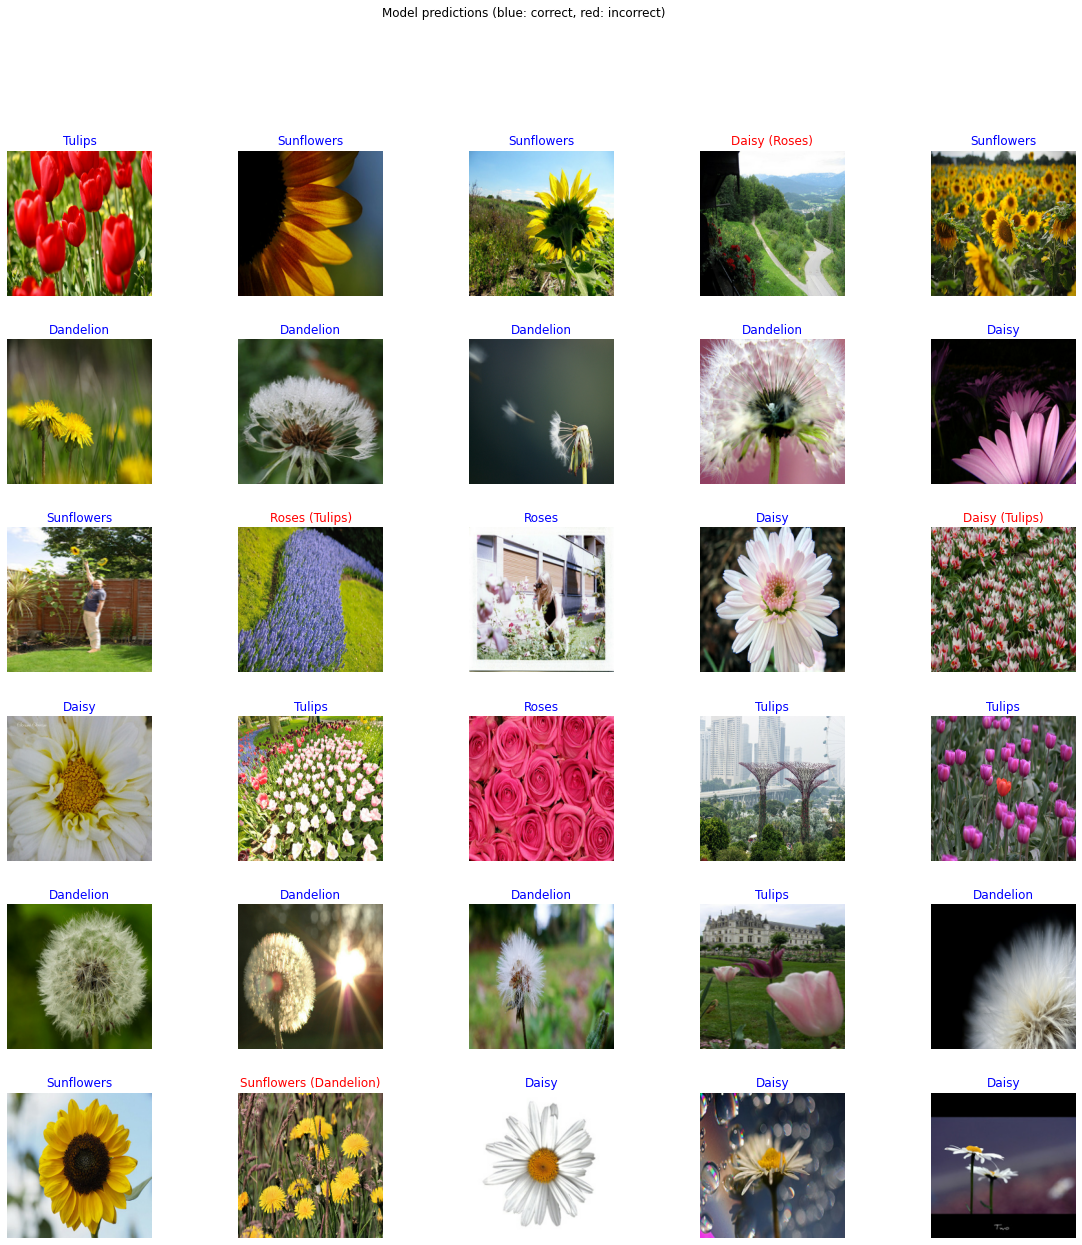

In [32]:
plt.figure(figsize=(20,20))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(images[n])
    color = 'blue' if labels[n] == predicted_batch[n] else 'red'
    if labels[n] != predicted_batch[n]:
        t = named_pred[n].title() + ' (' + named_labels[n].title() + ')'
    else:
        t = named_pred[n].title()
    plt.title(t, color=color)
    plt.axis('off')
    st = 'Model predictions (blue: correct, red: incorrect)'
_ = plt.suptitle(st)